* This notebook was made to look at the salinity / U, V velocity vertical profiles with reduced viscosity, nowcasts, no_banks at Sandheads, VENUS central/east/delta and station S4-3

In [1]:
from __future__ import division

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
)
from glob import glob
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import seaborn as sns
import requests

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 426,
        'j' : 293
   
    },
    'VENUS East':{
        'lat' : 49.0419,
        'lon' : -123.3176,
        'depth' : 170,
        'i' : 416,
        'j' : 283
    },    
    'VENUS Central': {
        'lat': 49.0401,
        'lon': -123.4261,
        'depth' : 300,
        'i': 424,
        'j': 266
        },

    'VENUS Delta': {
        'lat': 49.0807167,
        'lon': -123.3400617,
        'i':  425,
        'j':284
    },
    'S4-3':{
        'lat': 49.25 ,
        'lon':  -123.375,
        'i':461,
        'j': 300
        
    },

        }
# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '16', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '14'}

In [4]:
grid_T = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/\
SalishSea_1h_20141008_20141010_grid_T.nc')
grid_U = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/\
SalishSea_1h_20141008_20141010_grid_U.nc')
grid_V = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/\
SalishSea_1h_20141008_20141010_grid_V.nc')

grid_TT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
grid_UU = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_U.nc')
grid_VV = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_V.nc')

In [5]:
def plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,station_name,start_t,duration):
    """This function was made to plot vertical profiles of 
        salinity and magnitude of U&V velocity hourly"""
    salinity1 = grid_T.variables['vosaline']
    salinity2 = grid_TT.variables['vosaline']
    dd= []
    for d in np.arange(40):
        if salinity1[0,d,sites[station_name]['i'],sites[station_name]['j']] ==0:
            dd.append(d)
    index_d = min(dd)
    
    
    u1 = grid_U.variables['vozocrtx']
    v1= grid_V.variables['vomecrty']
    u2 = grid_UU.variables['vozocrtx']
    v2= grid_VV.variables['vomecrty']
    
    depth = grid_T.variables['deptht'][:]
    time=np.array([])
    t = nc_tools.timestamp(grid_T, np.arange(duration+ start_t))
    for ind in range(len(t)):
        t[ind] = t[ind].datetime
    time = np.append(time, t[start_t:start_t+duration+1]) 
    


    fig, axs =plt.subplots(duration,3, figsize = (20,40))
    for tt in range(duration):
        ## for salinity
        ax = axs[tt, 0]
        ax.plot(salinity1[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d], label = 'reduced')
        ax.plot(salinity2[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d], label = 'default')
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([10,34])
        ax.set_xlabel('Pratical Salinity')
        ax.set_ylabel('Depth')
        ax.legend(fontsize = 20)
        ## for U velocity
        ax = axs[tt, 1]
        ax.plot(u1[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],label = 'reduced')
        ax.plot(u2[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],label = 'default')
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([-0.7,0.7])
        ax.set_xlabel('U velocity[m/s]')
        ax.set_ylabel('Depth')
        ax.legend(fontsize = 20)
        ## for V velocity
        ax = axs[tt, 2]
        ax.plot(v1[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],label = 'reduced')
        ax.plot(v2[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d],label = 'default')
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([-0.5,0.5])
        ax.set_xlabel('V velocity[m/s]')
        ax.set_ylabel('Depth')
        ax.legend(fontsize = 20)
        
    return fig

In [ ]:
def plot_UVS(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,station_name,start_t):
    """This function was made to plot vertical profiles of 
        salinity and magnitude of U&V velocity hourly"""
    salinity1 = grid_T.variables['vosaline']
    salinity2 = grid_TT.variables['vosaline']
    
    ssh = grid_T.variables['sossheig']
    dd= []
    for d in np.arange(40):
        if salinity1[0,d,sites[station_name]['i'],sites[station_name]['j']] ==0:
            dd.append(d)
    index_d = min(dd)
    
    
    u1 = grid_U.variables['vozocrtx']
    v1= grid_V.variables['vomecrty']
    u2 = grid_UU.variables['vozocrtx']
    v2= grid_VV.variables['vomecrty']
    
    depth = grid_T.variables['deptht'][:]
    time=np.array([])
    t = nc_tools.timestamp(grid_T, np.arange(9+ start_t))
    for ind in range(len(t)):
        t[ind] = t[ind].datetime
    t_ssh = np.array(t) 
    time = np.append(time, t[start_t:start_t+9+1]) 
    

    
    fig, axs =plt.subplots(4,4, figsize = (40,40))
    for ax in axs[0,:]:
        ## for ssh
        #ax = axs[tt, 0]
        ax.plot(t_ssh,ssh[:, 466,329])
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([10,34])
        ax.set_xlabel('time')
        ax.set_ylabel('Sea surface height [m]')
        ## for U velocity
        ax = axs[tt, 1]
        ax.plot(u[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d])
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([-0.7,0.7])
        ax.set_xlabel('U velocity[m/s]')
        ax.set_ylabel('Depth')
        ## for V velocity
        ax = axs[tt, 2]
        ax.plot(v[start_t + tt, 0:index_d, sites[station_name]['i'],\
                         sites[station_name]['j']], -depth[0:index_d])
        ax.set_title(time[tt].strftime('%d-%b-%Y %H:%M') + ' at '+ station_name, **title_font)
        ax.set_xlim([-0.5,0.5])
        ax.set_xlabel('V velocity[m/s]')
        ax.set_ylabel('Depth')        
        
    return fig

* Sandheads

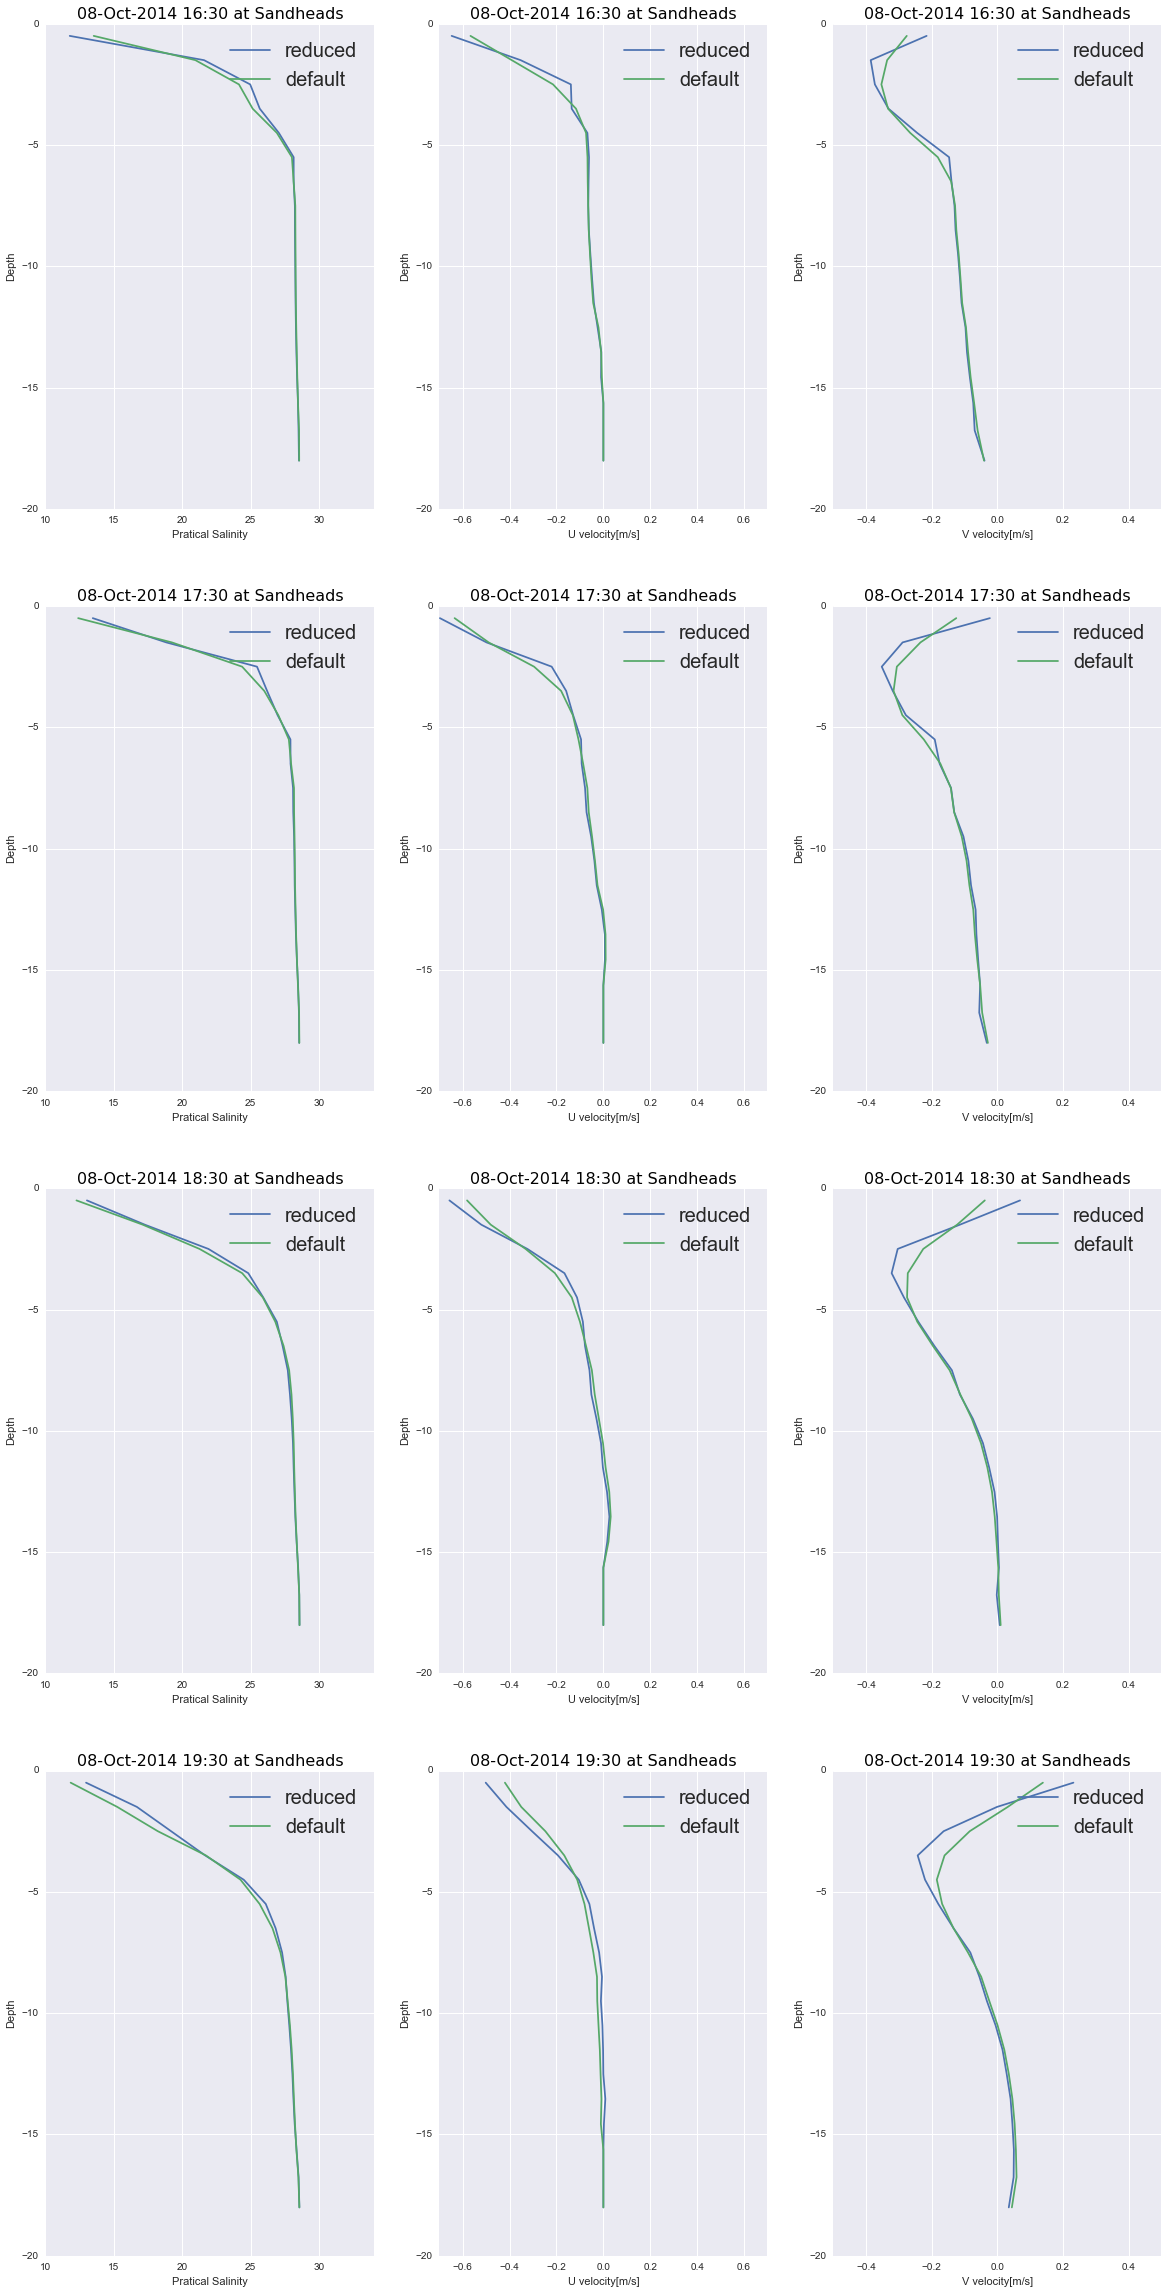

In [6]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'Sandheads', 16,4)

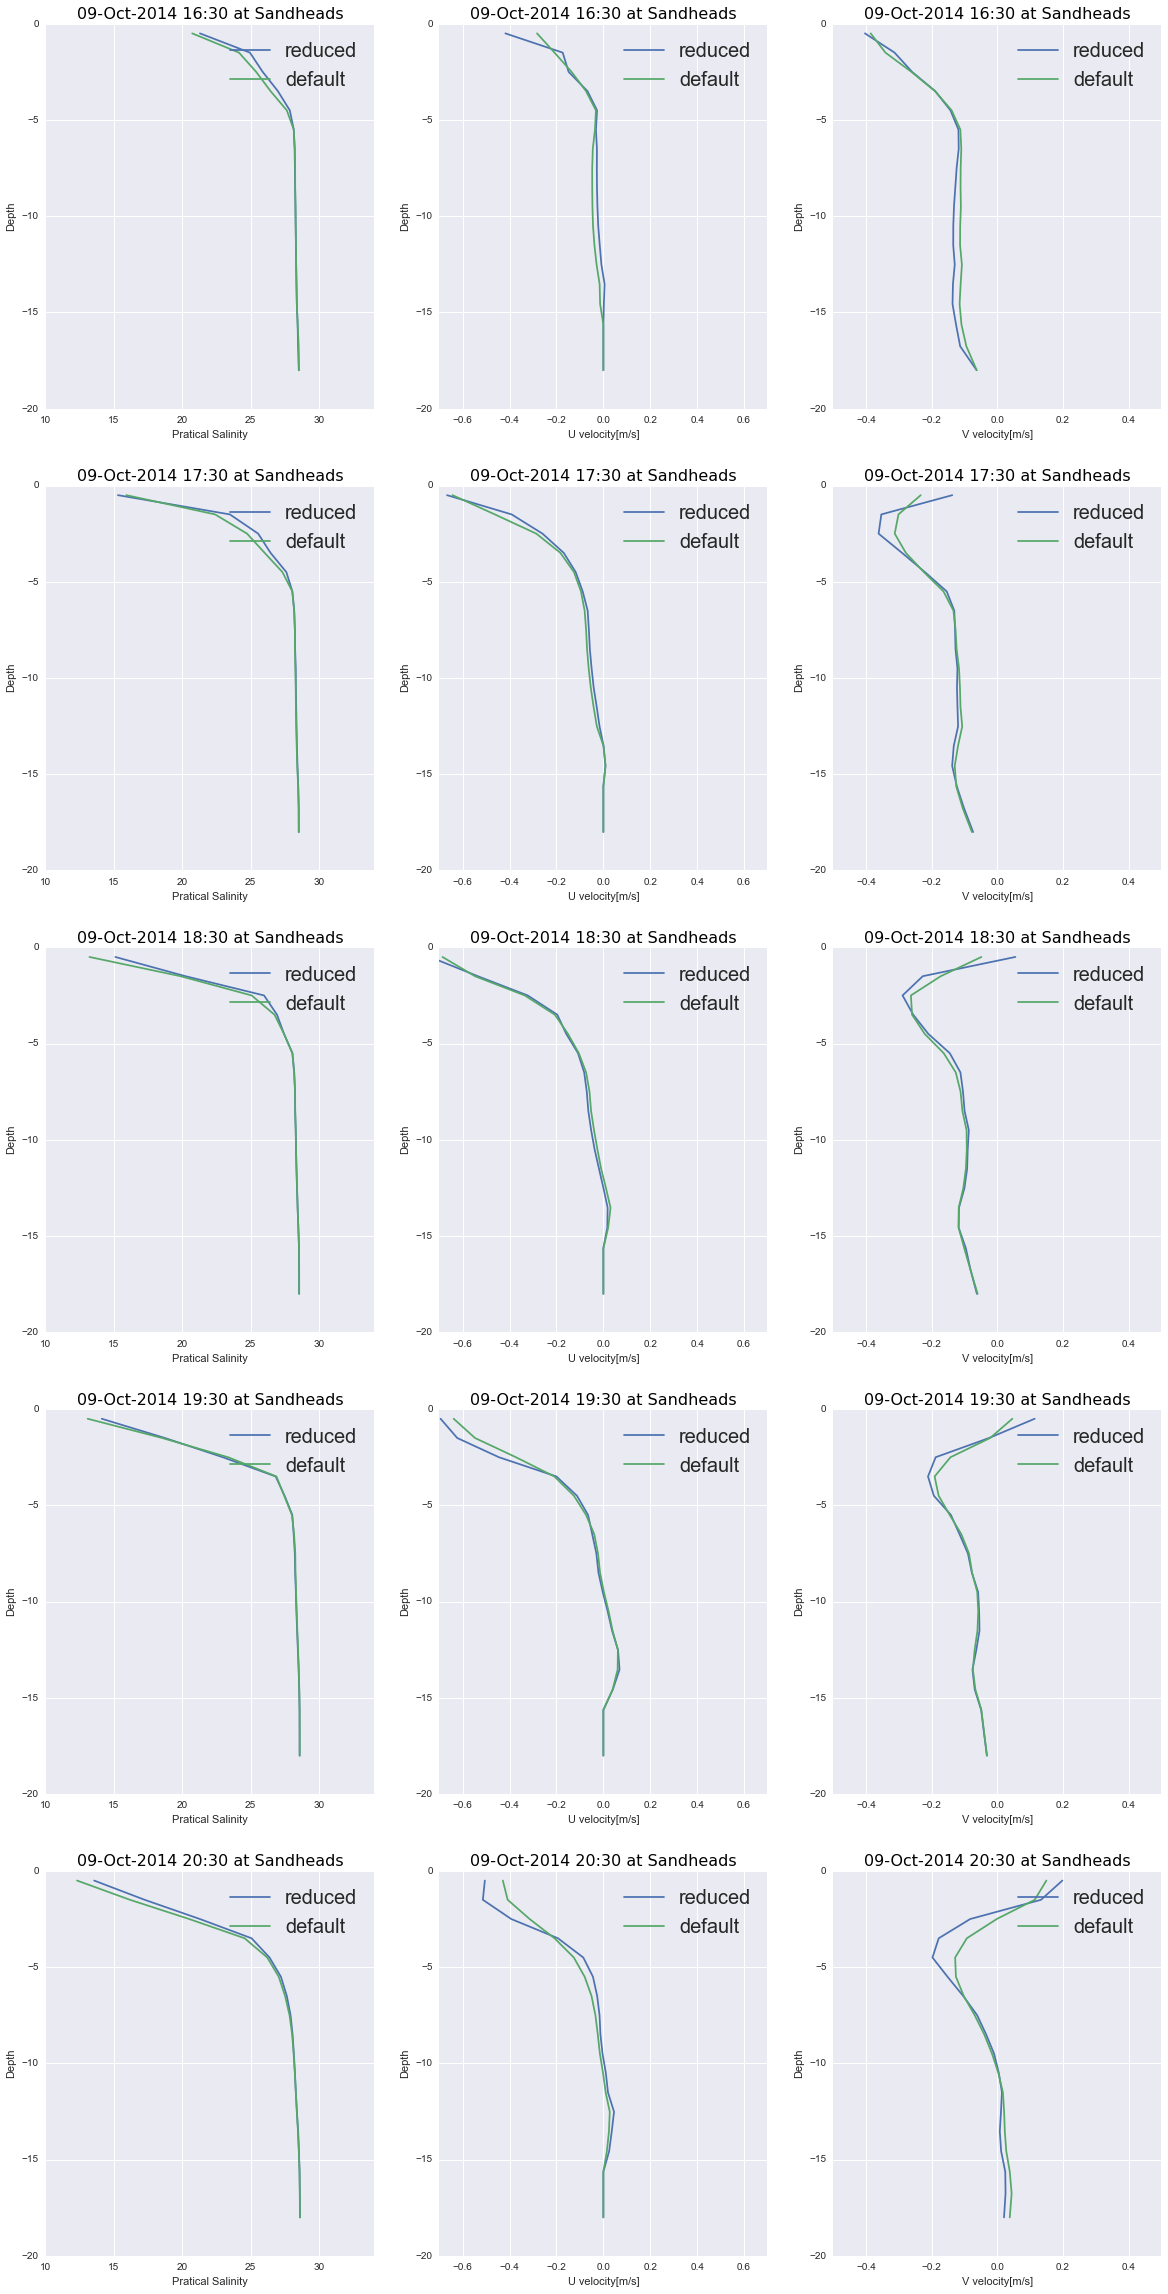

In [7]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'Sandheads', 40,5)

* VENUS Central

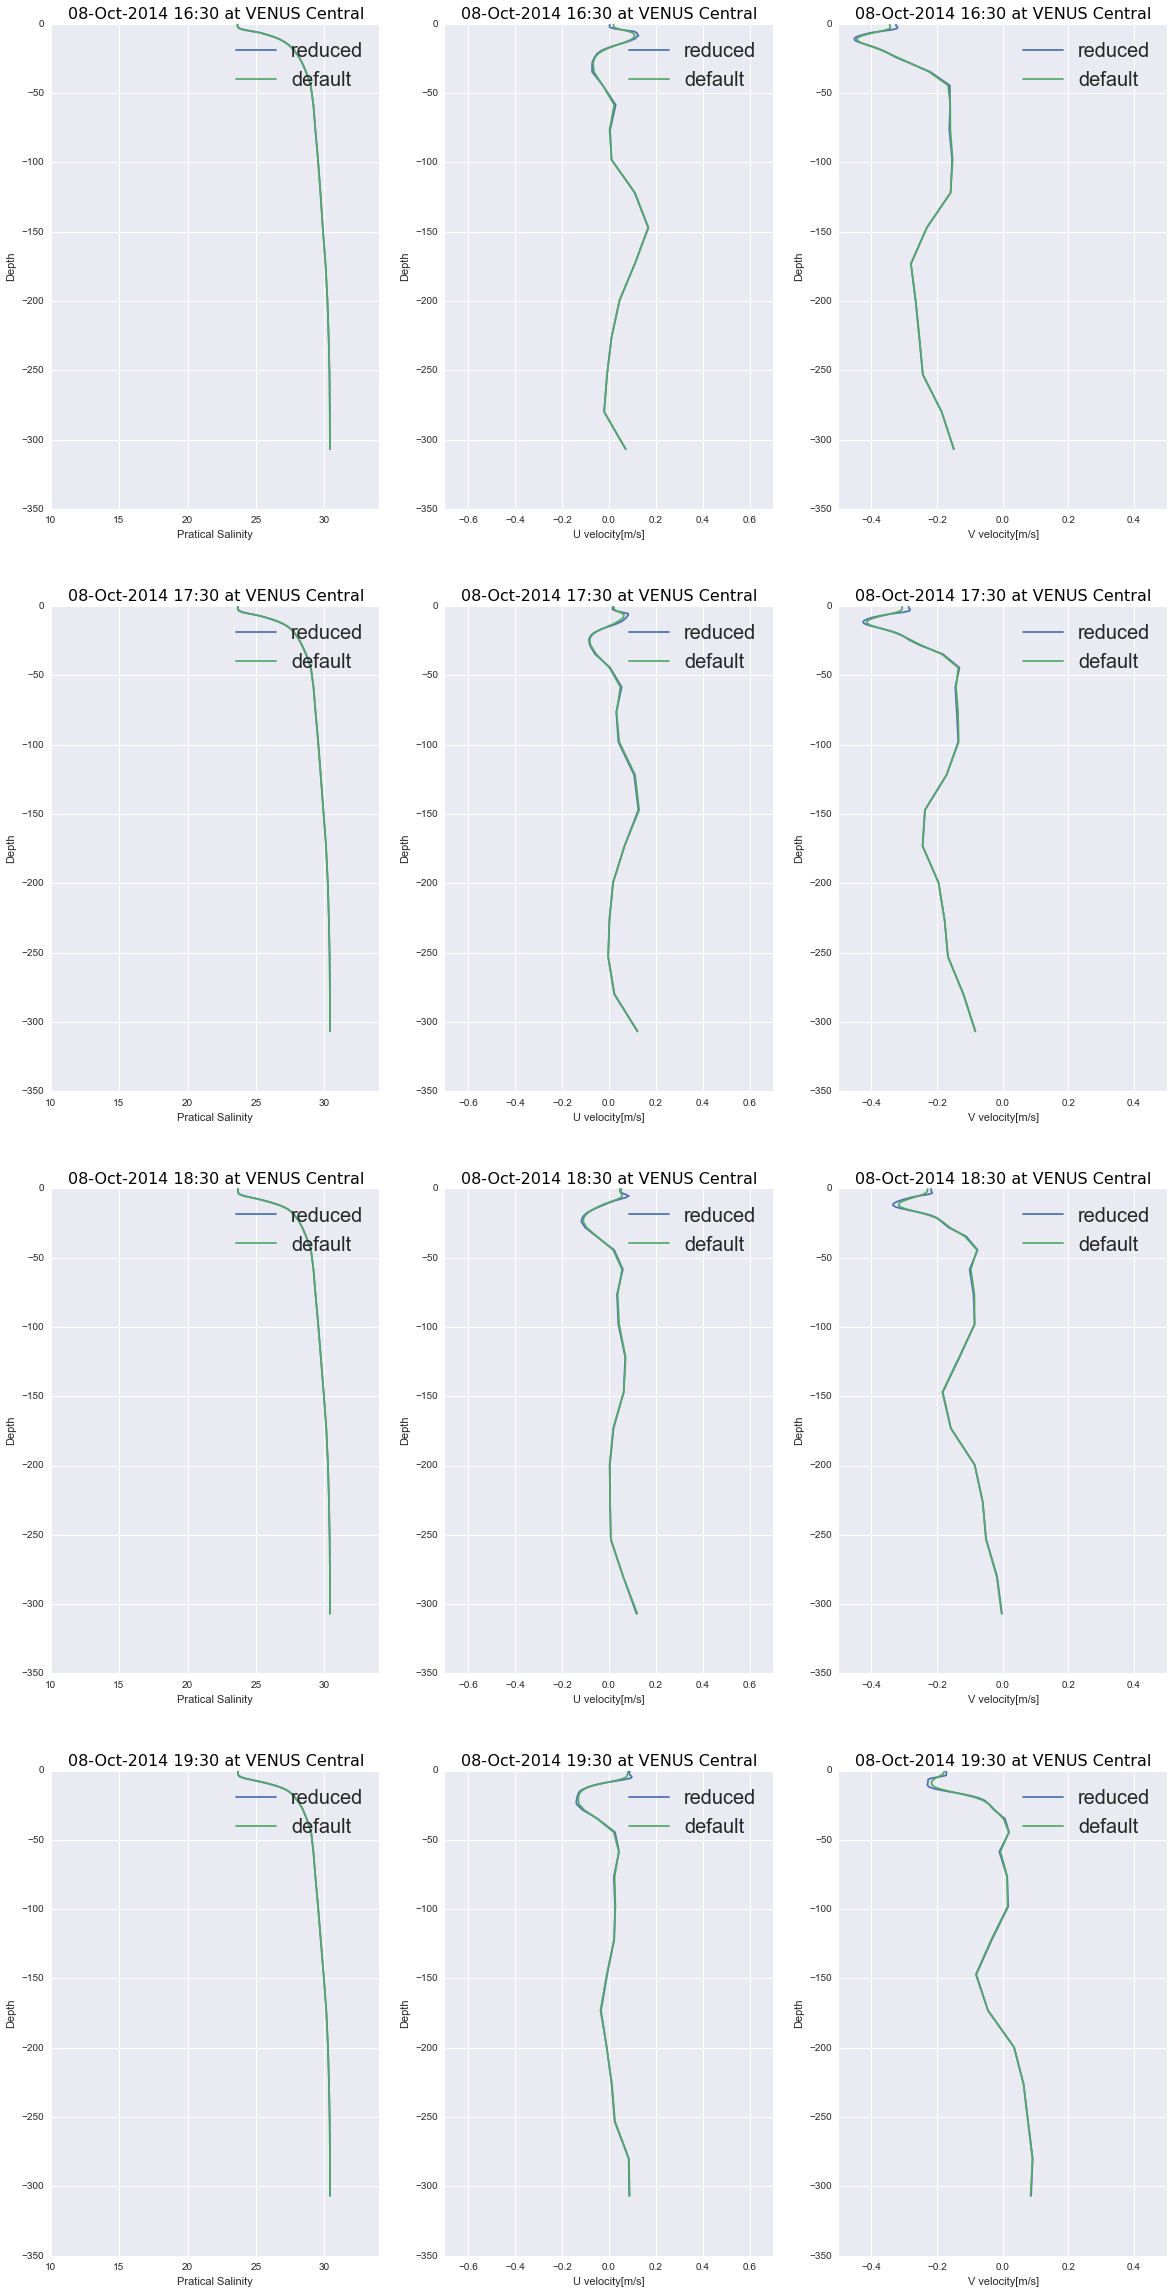

In [8]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'VENUS Central', 16,4)

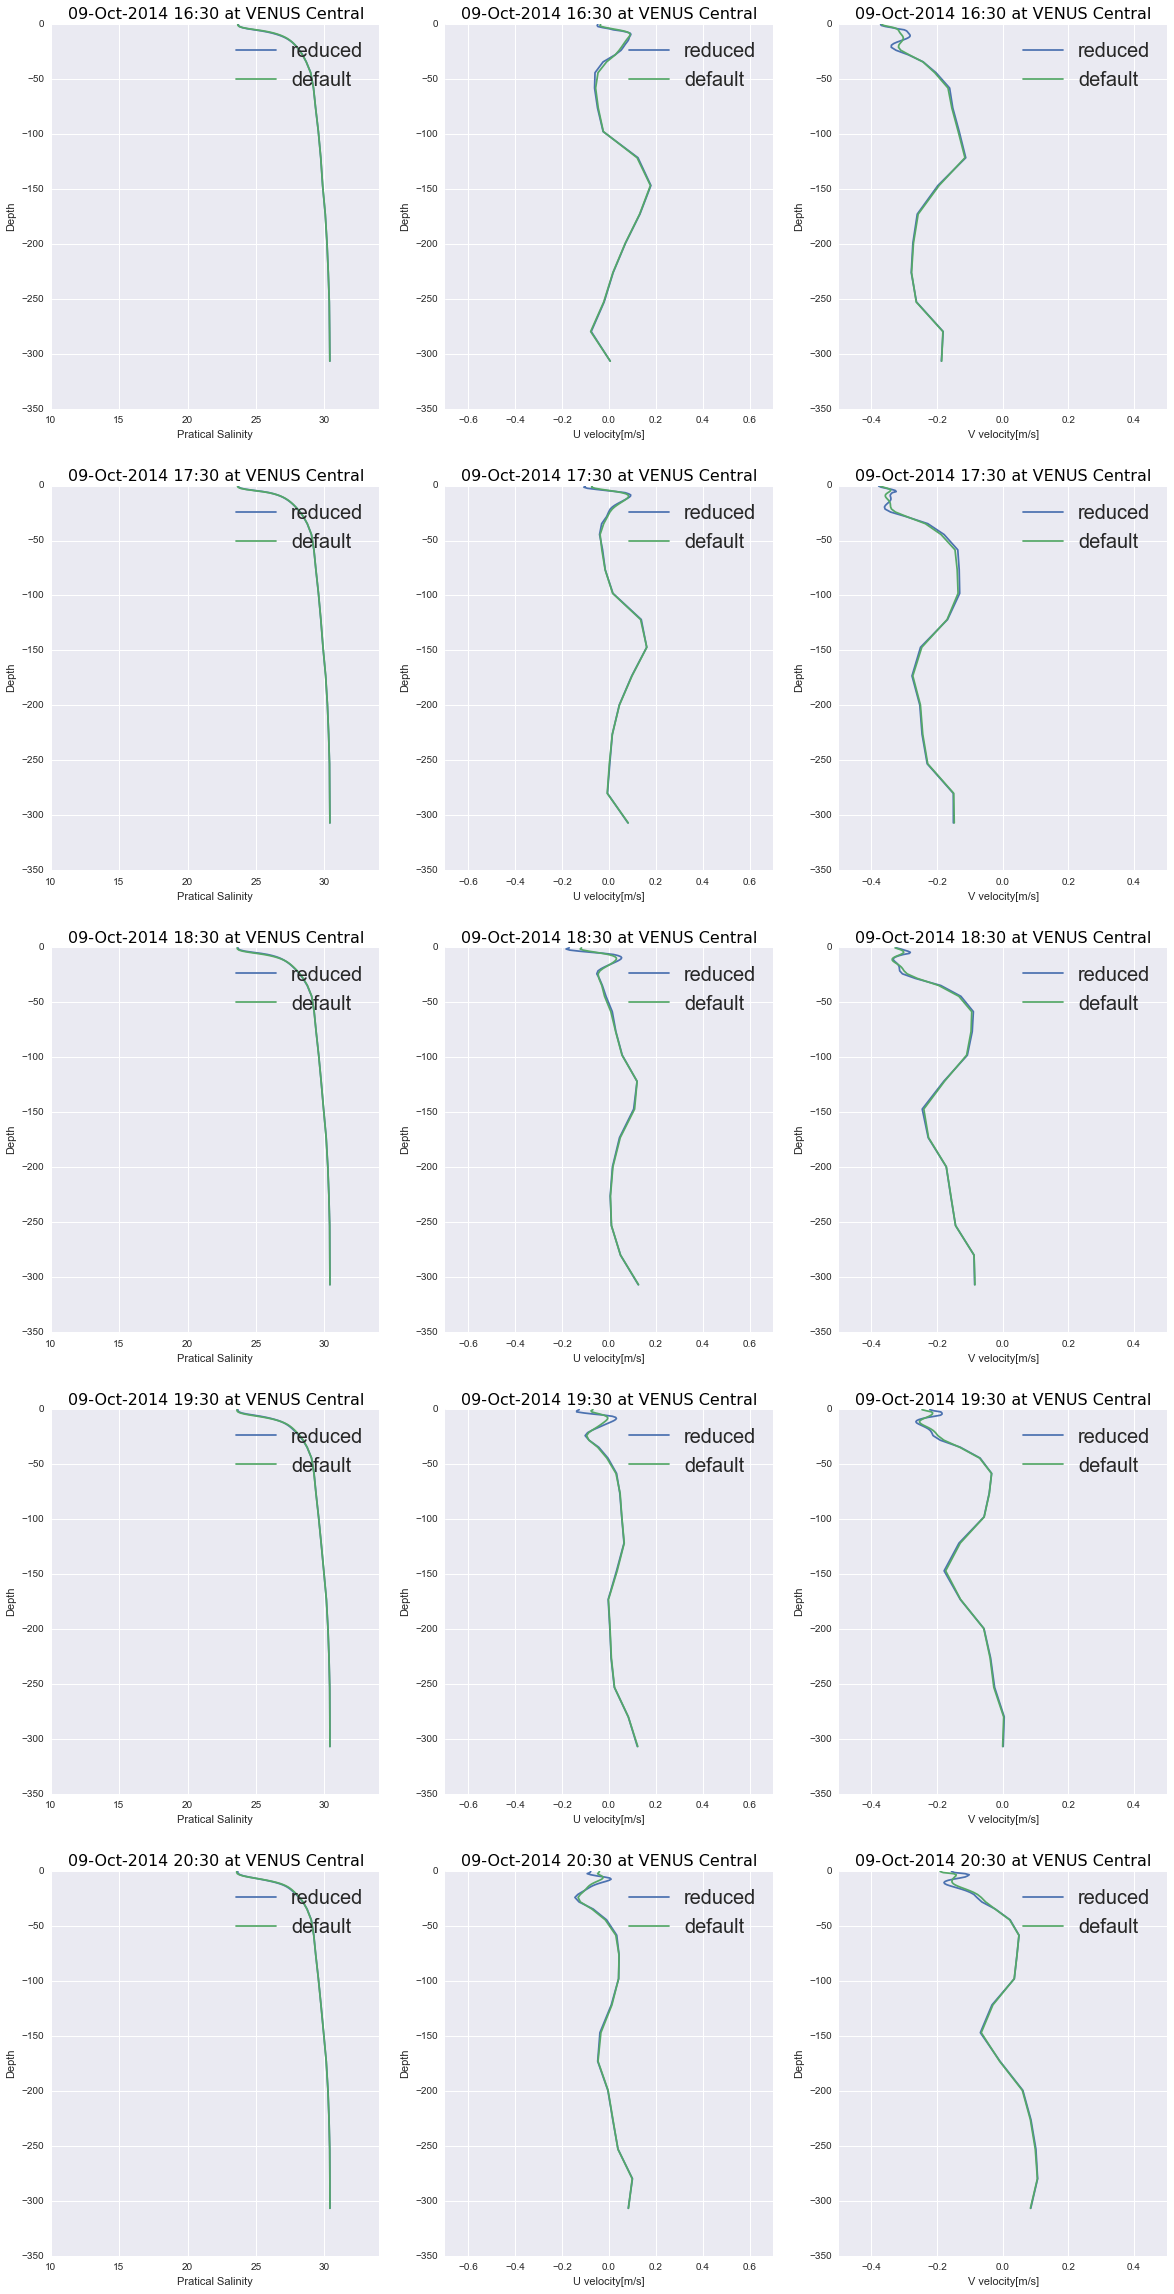

In [9]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'VENUS Central', 40,5)

* VENUS East

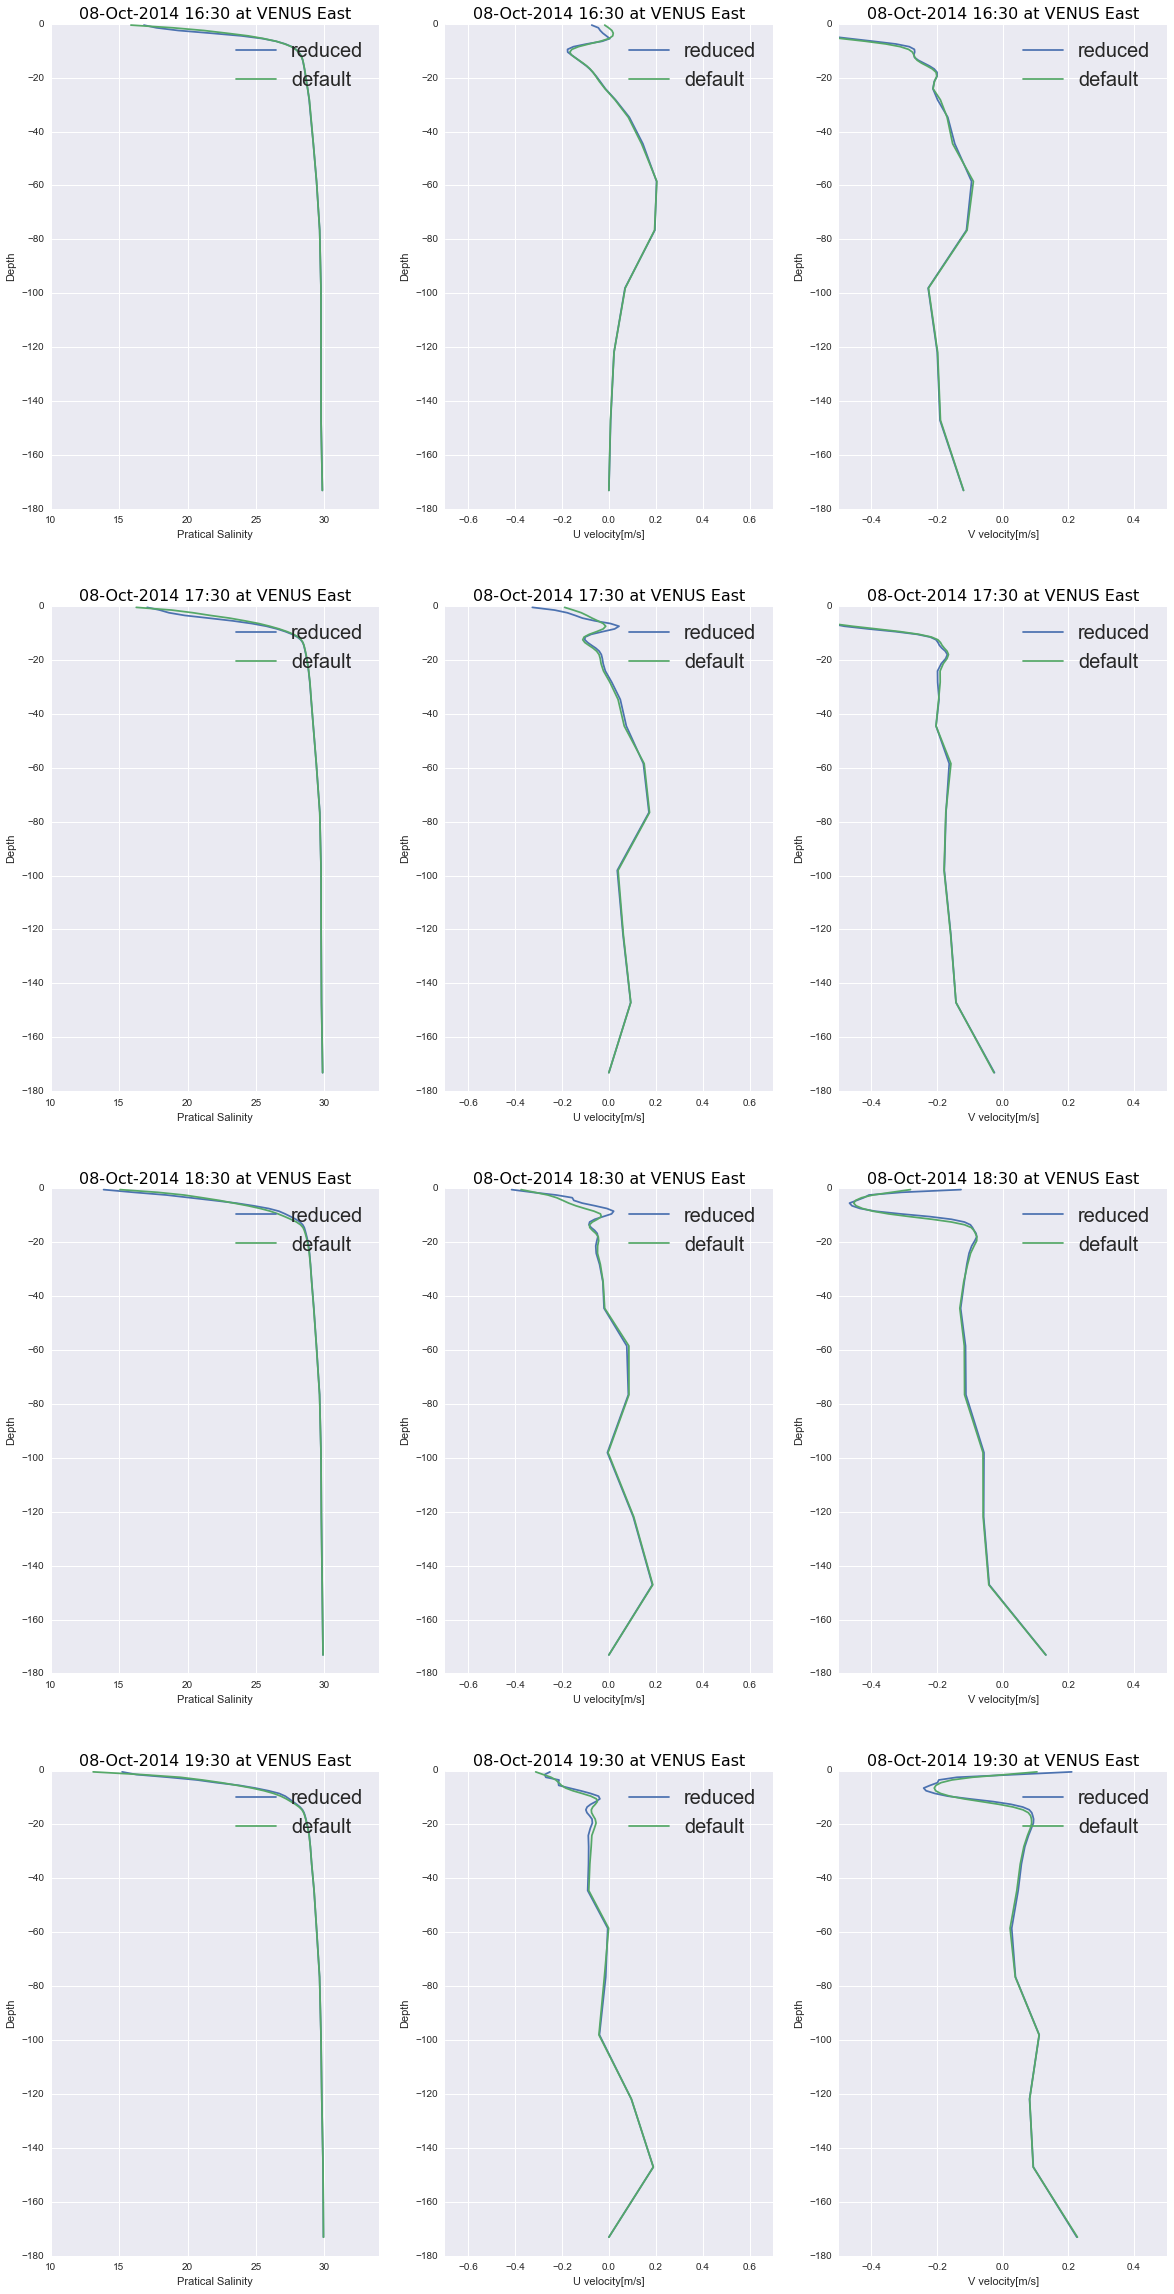

In [10]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'VENUS East', 16,4)

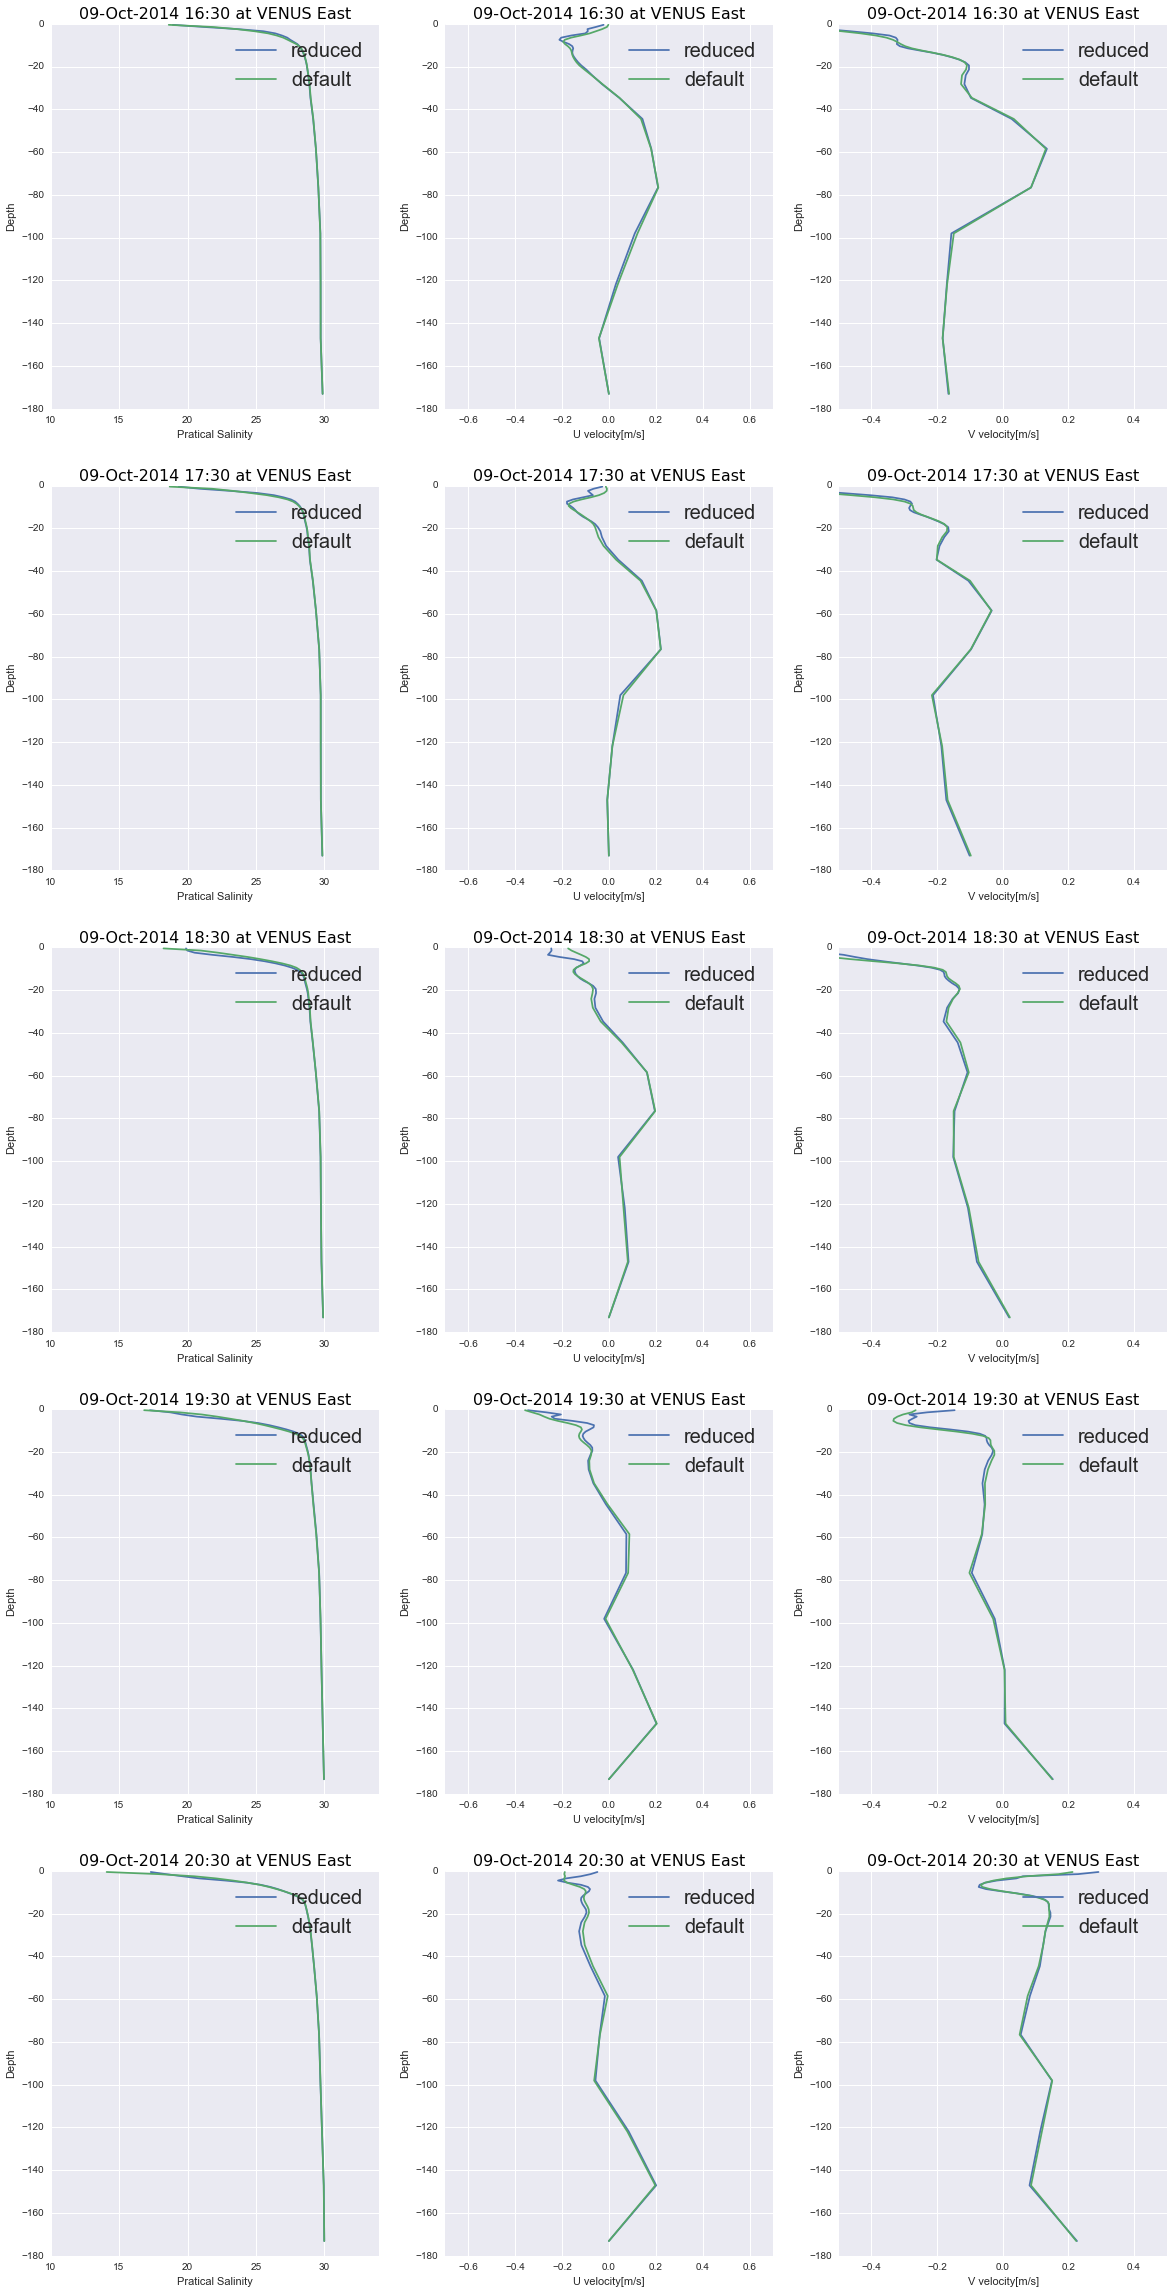

In [11]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'VENUS East', 40,5)

* VENUS Delta

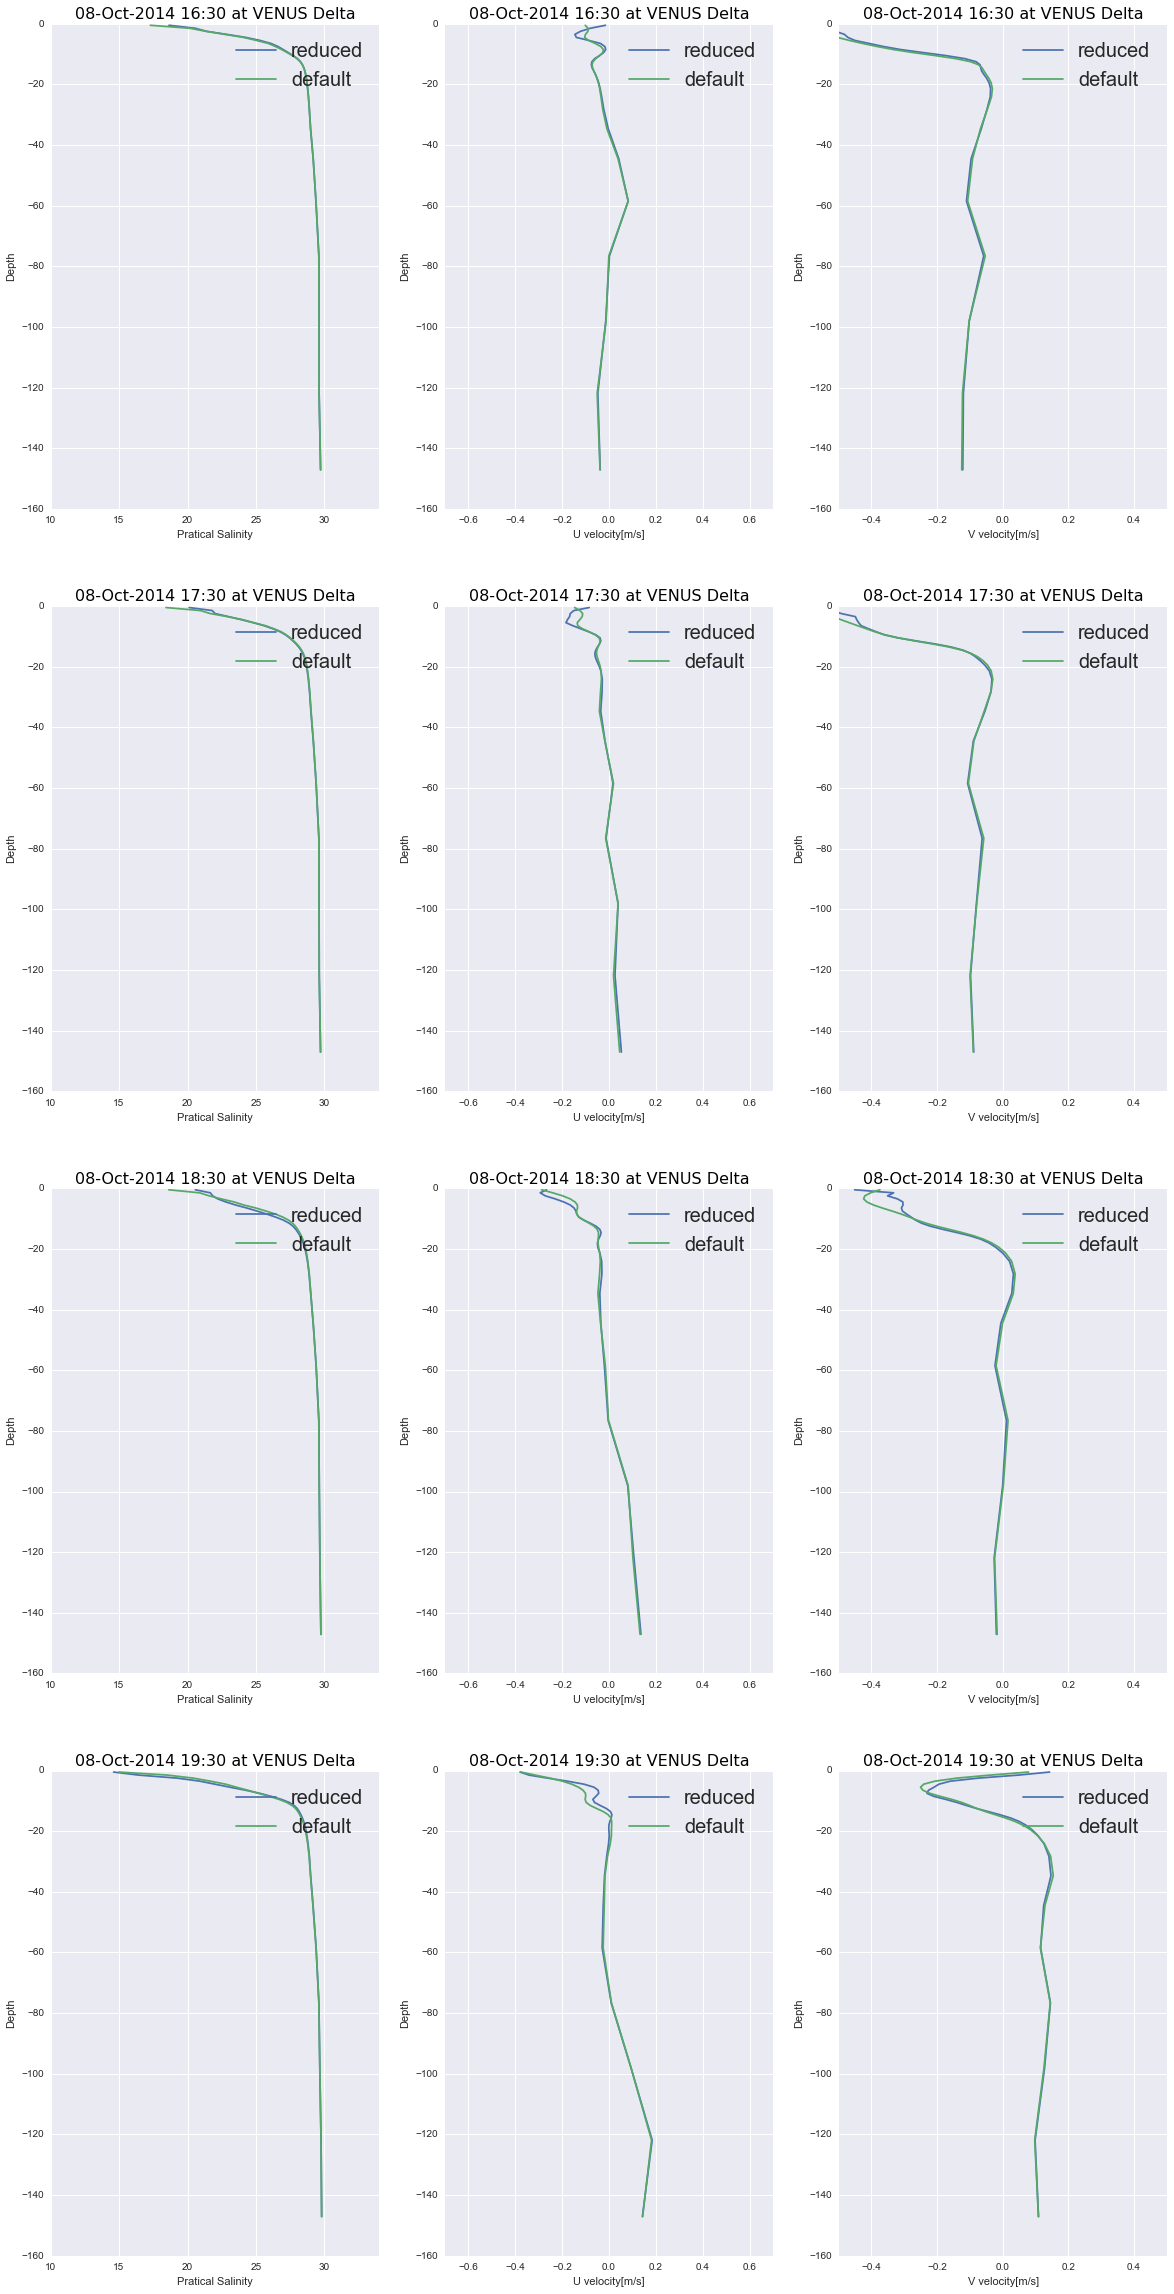

In [12]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'VENUS Delta', 16,4)

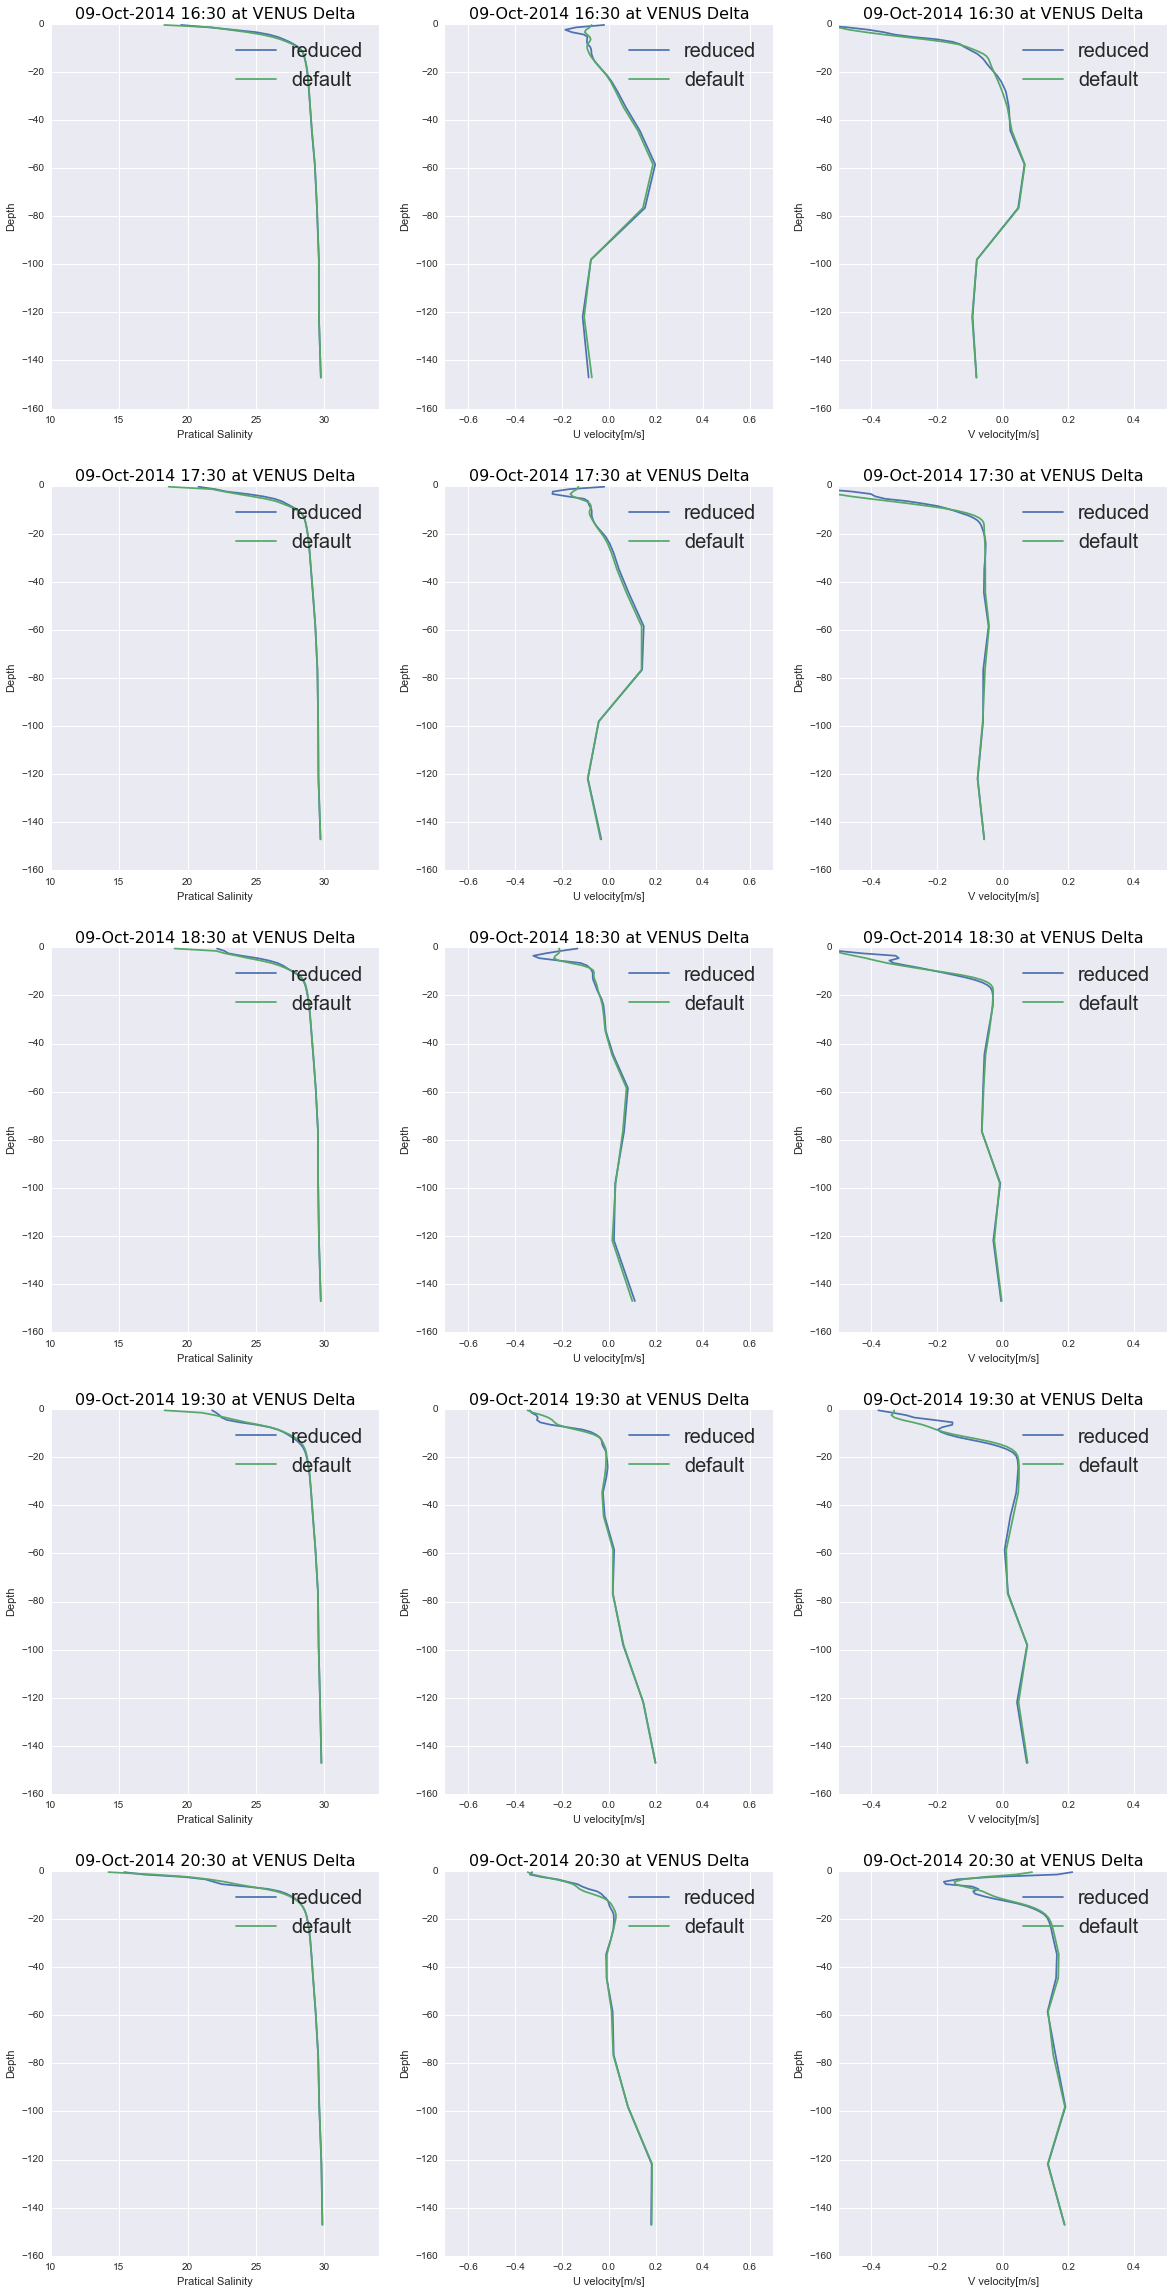

In [13]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'VENUS Delta', 40,5)

* S4-3

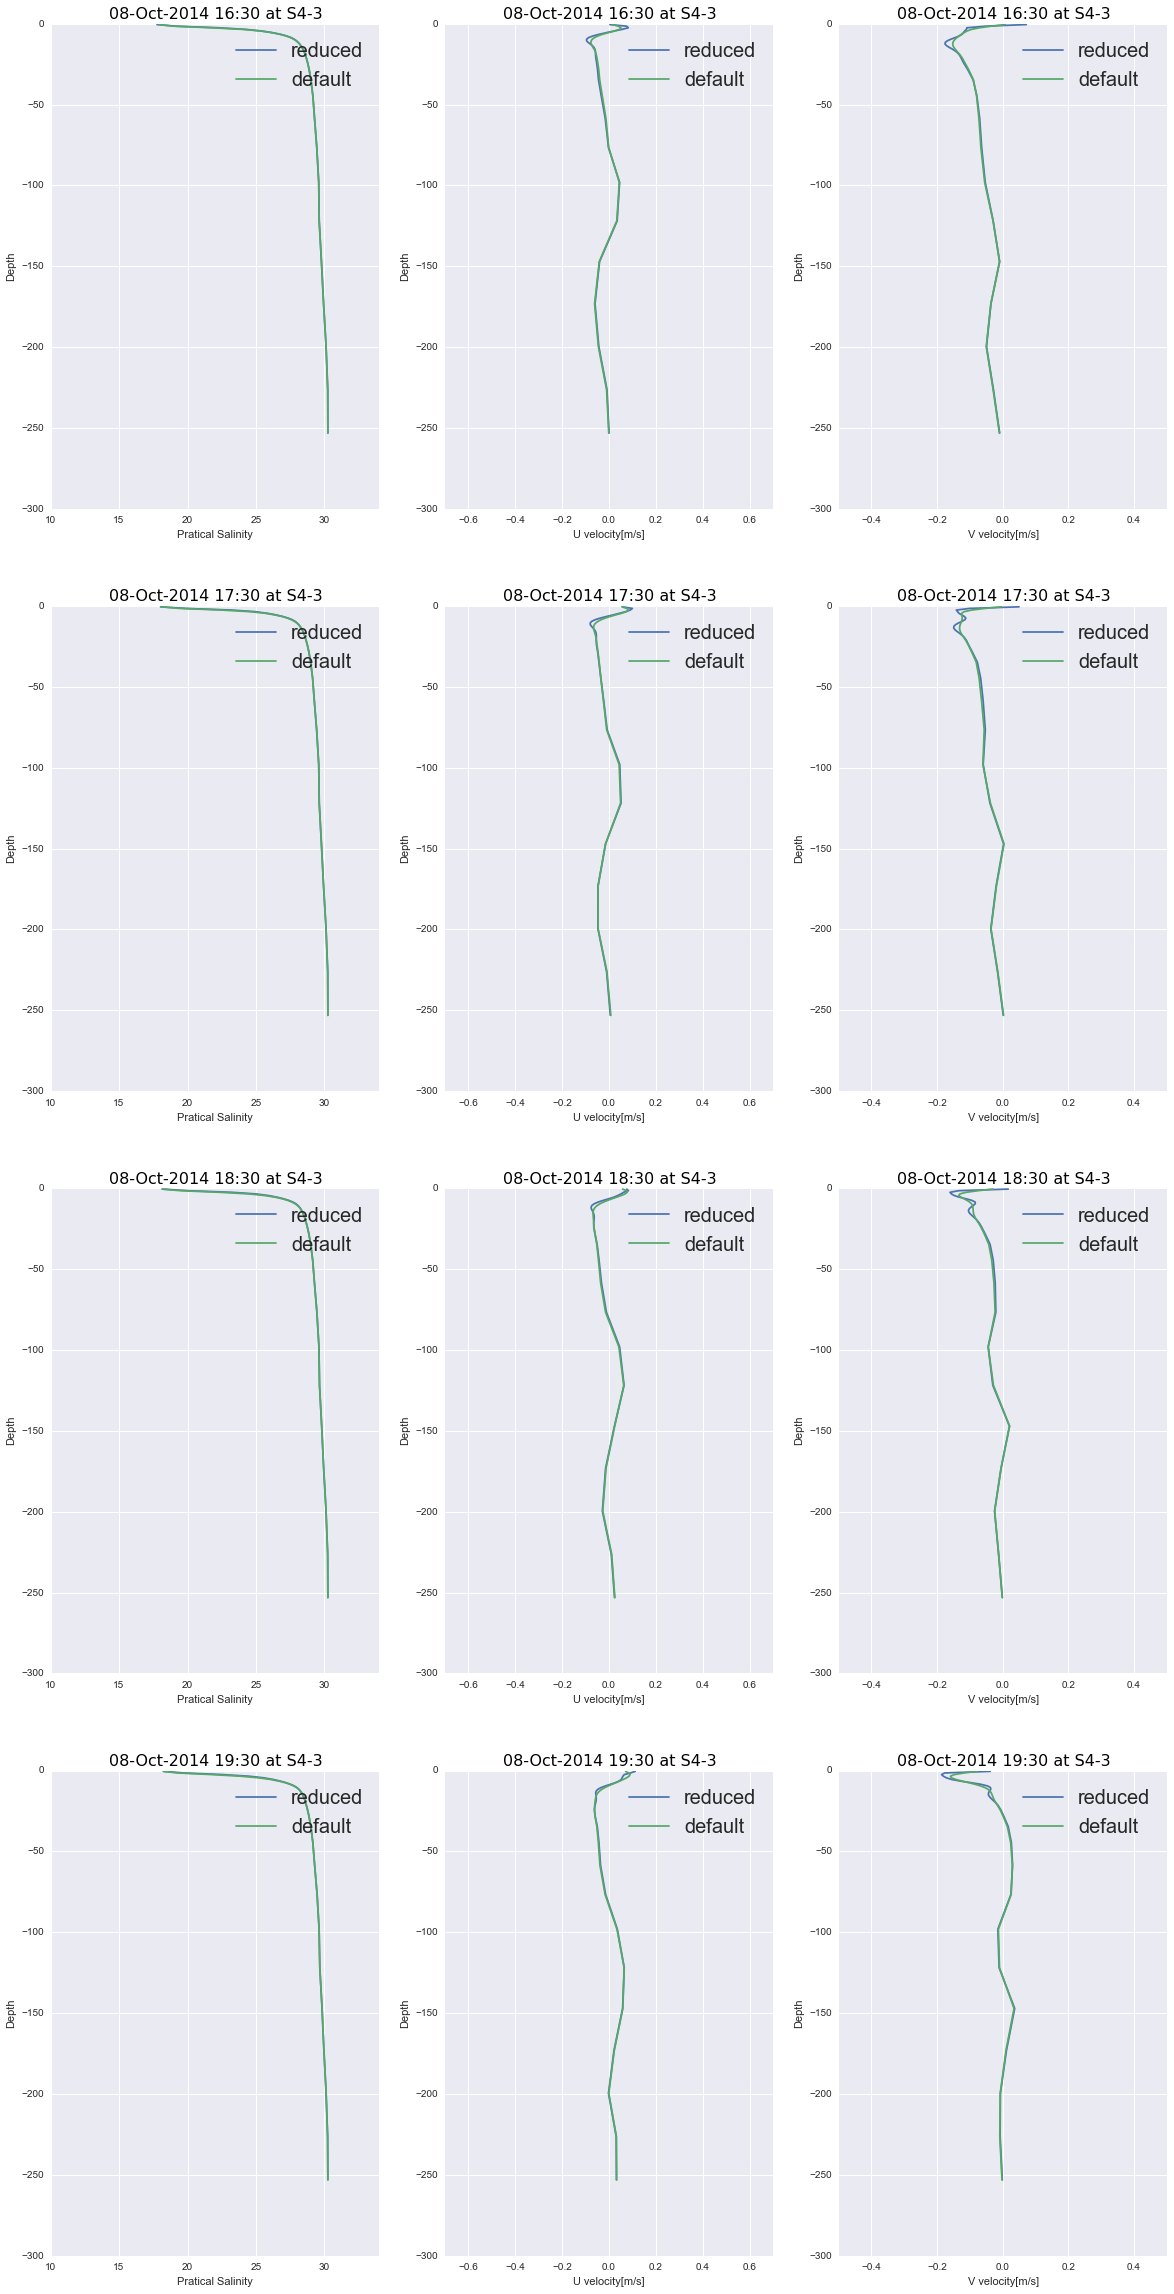

In [14]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'S4-3', 16,4)

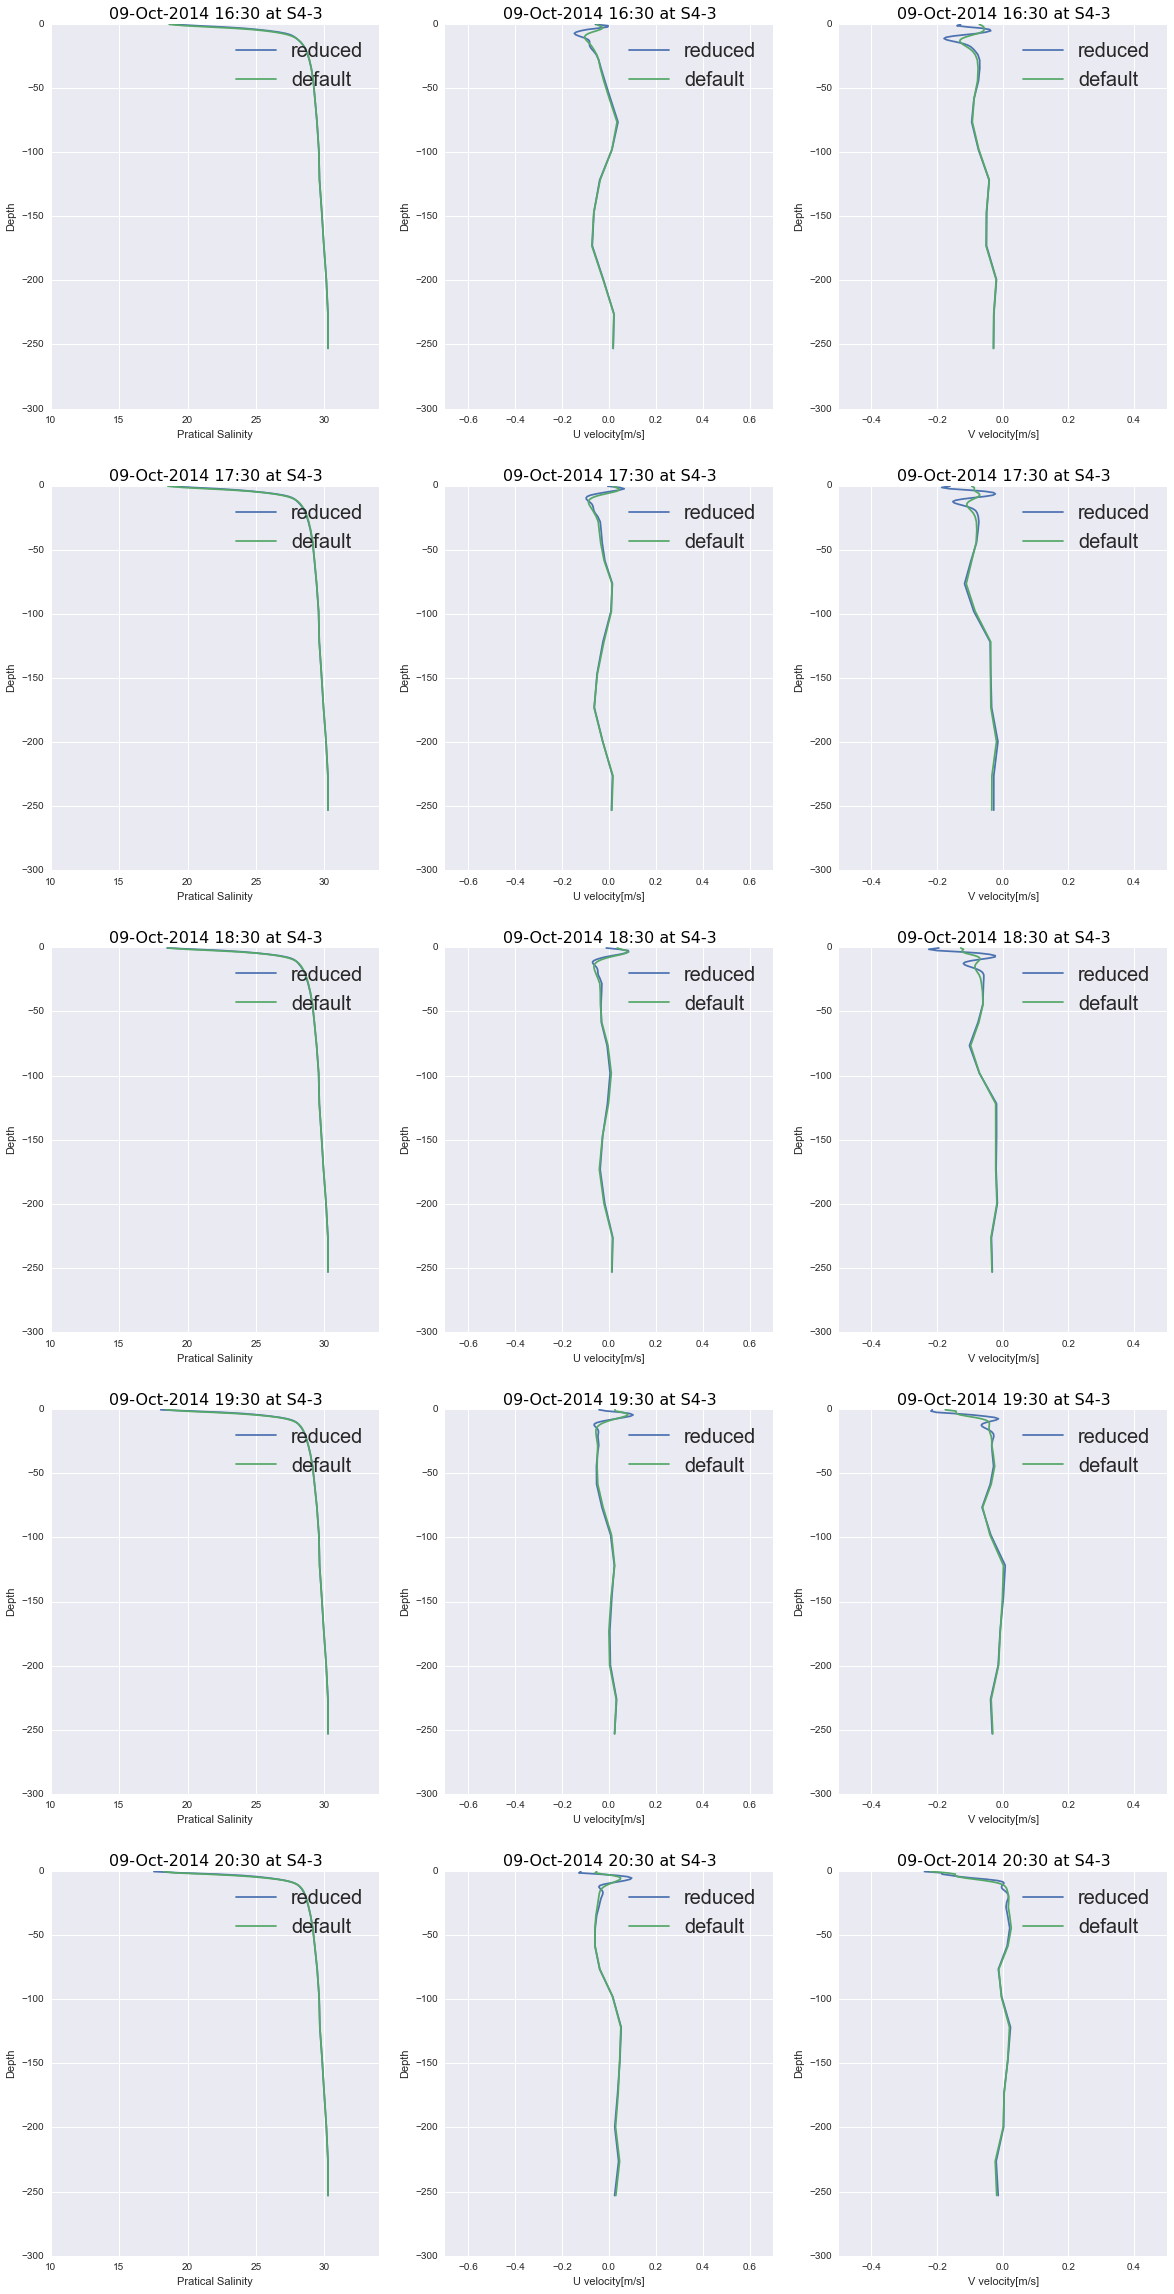

In [15]:
fig = plot_salinity_UV(grid_T,grid_U,grid_V,grid_TT,grid_UU,grid_VV,'S4-3', 40,5)